In [2]:
import pandas as pd

# Load the provided Excel file
file_path = 'data.xlsx'

# Read the Excel file to get the sheet names
xls = pd.ExcelFile(file_path)

# Read each sheet into a separate DataFrame
dfs = {sheet_name: pd.read_excel(xls, sheet_name) for sheet_name in xls.sheet_names}

# To verify, let's return the sheet names
sheet_names = xls.sheet_names
sheet_names

['Electricity Load', 'Gas Load', 'Solar', 'Wind']

In [3]:
date_range = pd.date_range(start='1/1/2024', end='12/31/2024', freq='15T')[:-1]

In [4]:
import numpy as np
import pandas as pd

def create_year_data(df, noise_level=0.1):
    # Define the exact days in each quarter to cover 365 days total
    num_days = [91, 91, 91, 92]  # Adjusted for a non-leap year with 365 days

    # Define the start day of each quarter
    quarter_starts = np.cumsum([0] + num_days[:-1])

    # Create a full year's date range
    date_range = pd.date_range(start='1/1/2024', end='12/31/2024', freq='15T')[:-1]

    # Initialize an empty DataFrame with the date_range as index
    columns = df['Location_Electricity'].unique()
    yearly_data = pd.DataFrame(index=date_range, columns=columns)

    # Iterate over each location and quarter
    for location in df['Location_Electricity'].unique():
        for quarter, start_day, days in zip(df['Quarter'].unique(), quarter_starts, num_days):
            # Filter data for current location and quarter
            day_data = df[(df['Location_Electricity'] == location) & (df['Quarter'] == quarter)]['Load']
            
            # Generate the data for the entire quarter
            for day in range(days):
                start_datetime = pd.Timestamp('2024-01-01') + pd.Timedelta(days=start_day + day)
                day_times = pd.date_range(start=start_datetime, periods=96, freq='15T')
                
                # Add iid Gaussian noise
                noise = np.random.normal(0, day_data.mean() * noise_level, size=day_data.shape[0])
                noisy_day_data = day_data.values + noise
                
                # Assign the data to the correct column in the DataFrame
                yearly_data.loc[day_times, location] = noisy_day_data
    
    return yearly_data

# Apply the function to the 'Electricity Load' DataFrame with an example noise level of 10%
final_data = create_year_data(dfs['Electricity Load'], noise_level=0.1)



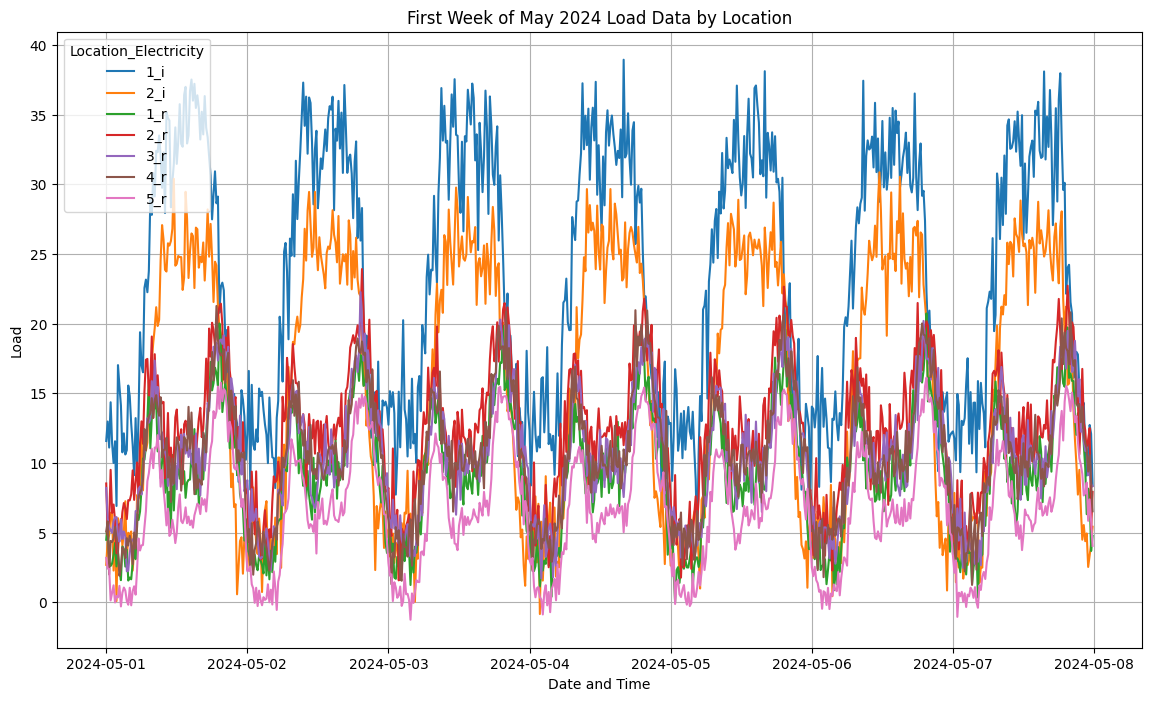

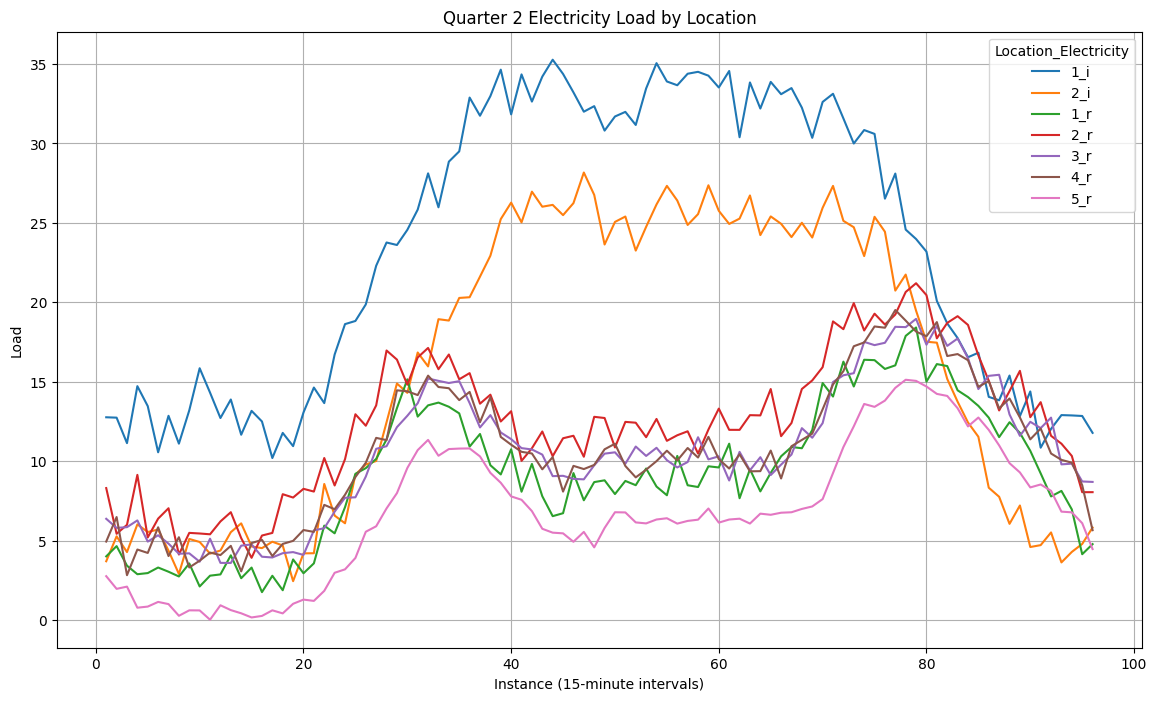

In [5]:
import matplotlib.pyplot as plt

# Select data for the first week of March 2024
first_week_march = final_data['2024-05-01':'2024-05-07']

# Plotting the data for the first week of March
plt.figure(figsize=(14, 8))
for column in first_week_march.columns:
    plt.plot(first_week_march.index, first_week_march[column], label=column)

plt.title('First Week of May 2024 Load Data by Location')
plt.xlabel('Date and Time')
plt.ylabel('Load')
plt.legend(title='Location_Electricity')
plt.grid(True)
plt.show()


import matplotlib.pyplot as plt

# Filter data for Quarter 1
q1_data = dfs['Electricity Load'][dfs['Electricity Load']['Quarter'] == 'Q2']

# Plotting the data
plt.figure(figsize=(14, 8))
for location in q1_data['Location_Electricity'].unique():
    # Filter data for each location
    location_data = q1_data[q1_data['Location_Electricity'] == location]
    
    # Plot the load data
    plt.plot(location_data['Instance'], location_data['Load'], label=location)

plt.title('Quarter 2 Electricity Load by Location')
plt.xlabel('Instance (15-minute intervals)')
plt.ylabel('Load')
plt.legend(title='Location_Electricity')
plt.grid(True)
plt.show()


In [6]:
import numpy as np
import pandas as pd

def expand_energy_data(df, column_name, energy_type, noise_level=0.1):
    # Define the number of days in each quarter to cover 365 days total
    num_days = [91, 91, 91, 92]  # Adjusted for a non-leap year with 365 days
    quarter_starts = np.cumsum([0] + num_days[:-1])

    # Create a full year's date range
    date_range = pd.date_range(start='1/1/2024', end='12/31/2024', freq='15T')[:-1]

    # Initialize an empty DataFrame with the date_range as index
    yearly_data = pd.Series(index=date_range, dtype=float)

    # Iterate over each quarter
    for quarter, start_day, days in zip(df['Quarter'].unique(), quarter_starts, num_days):
        # Filter data for the current quarter
        quarter_data = df[df['Quarter'] == quarter][column_name]
        
        # Generate the data for the entire quarter
        for day in range(days):
            start_datetime = pd.Timestamp('2024-01-01') + pd.Timedelta(days=start_day + day)
            day_times = pd.date_range(start=start_datetime, periods=96, freq='15T')
            
            # Prepare noise
            noise = np.random.normal(0, quarter_data.mean() * noise_level, size=quarter_data.shape[0])
            
            # Conditionally apply noise and ensure non-negative results for Solar data
            noisy_day_data = quarter_data.values + noise
            noisy_day_data = np.where(quarter_data.values == 0, 0, noisy_day_data)
            noisy_day_data = np.maximum(0, noisy_day_data)  # Clip negative values to zero
            
            # Assign the noisy data to the corresponding times in the yearly series
            yearly_data[day_times] = noisy_day_data

    return yearly_data

# Apply the function to each energy DataFrame
wind_data = expand_energy_data(dfs['Wind'], 'Generation', 'Wind')
solar_data = expand_energy_data(dfs['Solar'], 'Generation', 'Solar', noise_level=0.1)  # Applying custom condition for Solar
gas_load_data = expand_energy_data(dfs['Gas Load'], 'Load', 'Gas Load')

# Append the generated series as columns to final_data
final_data['Wind'] = wind_data
final_data['Solar'] = solar_data
final_data['Gas Load'] = gas_load_data

# Now let's check the structure and a preview of the final_data
final_data.info(), final_data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2024-01-01 00:00:00 to 2024-12-30 23:45:00
Freq: 15T
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   1_i       35040 non-null  object 
 1   2_i       35040 non-null  object 
 2   1_r       35040 non-null  object 
 3   2_r       35040 non-null  object 
 4   3_r       35040 non-null  object 
 5   4_r       35040 non-null  object 
 6   5_r       35040 non-null  object 
 7   Wind      35040 non-null  float64
 8   Solar     35040 non-null  float64
 9   Gas Load  35040 non-null  float64
dtypes: float64(3), object(7)
memory usage: 3.9+ MB


(None,
                            1_i       2_i       1_r        2_r        3_r  \
 2024-01-01 00:00:00  10.871702  8.928885   7.00352   9.329634  17.645902   
 2024-01-01 00:15:00  13.635107  5.605044  5.578471   11.91102  13.706451   
 2024-01-01 00:30:00  15.076568  6.314087  4.654127  10.868752   9.397497   
 2024-01-01 00:45:00  13.529977  3.449956  5.904007  13.003289   9.350289   
 2024-01-01 01:00:00   9.363125  5.283971  4.751602   9.404036  12.106664   
 
                            4_r       5_r      Wind  Solar    Gas Load  
 2024-01-01 00:00:00  10.134582  8.078072  3.962172    0.0  736.589082  
 2024-01-01 00:15:00    7.54277  5.400679  1.438880    0.0  533.105786  
 2024-01-01 00:30:00  12.447039   6.12567  3.571683    0.0  549.907547  
 2024-01-01 00:45:00   9.803102   5.30859  2.979320    0.0  683.224929  
 2024-01-01 01:00:00  12.478595   5.88326  3.003006    0.0  528.768669  )

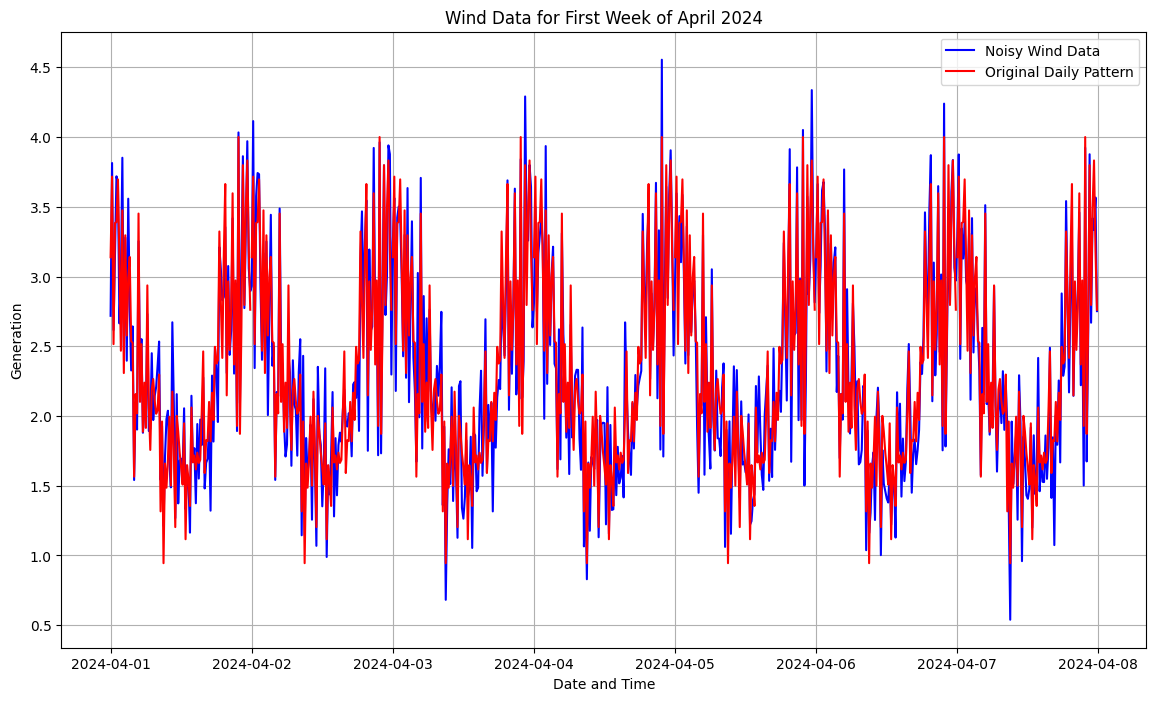

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Select the first week of April 2024 from final_data
# metric = 'Gas Load'
# colname = 'Load'
metric = 'Wind'
colname = 'Generation'
# metric = 'Solar'
# colname = 'Generation'
week_data = final_data['2024-04-01':'2024-04-07'][metric]

# Plotting the expanded noisy data
plt.figure(figsize=(14, 8))
plt.plot(week_data.index, week_data, label='Noisy Wind Data', color='blue')

# Filter the original Q2 Wind data
original_wind_data = dfs[metric][dfs[metric]['Quarter'] == 'Q2']

# Assuming that Instance 1-96 covers one day, we need to plot this for each day of the week
for i in range(7):  # 7 days in the week
    start_time = pd.Timestamp('2024-04-01') + pd.Timedelta(days=i)
    times = pd.date_range(start=start_time, periods=96, freq='15T')
    plt.plot(times, original_wind_data[colname], label='Original Daily Pattern' if i == 0 else "", color='red')

plt.title('Wind Data for First Week of April 2024')
plt.xlabel('Date and Time')
plt.ylabel(colname)
plt.legend()
plt.grid(True)
plt.show()


In [61]:
# Save the final_data DataFrame into a CSV file locally named "yearly_data.csv"
final_data.to_csv('yearly_data.csv')


In [8]:
######
# Generate dataset #
import os

# Ensure the 'data' directory exists
os.makedirs('data', exist_ok=True)
N = 10
# Loop to run the code 100 times
for i in range(1, N+1):
    final_data = create_year_data(dfs['Electricity Load'], noise_level=0.1)
    # Apply the function to each energy DataFrame
    wind_data = expand_energy_data(dfs['Wind'], 'Generation', 'Wind')
    solar_data = expand_energy_data(dfs['Solar'], 'Generation', 'Solar', noise_level=0.1)  # Applying custom condition for Solar
    gas_load_data = expand_energy_data(dfs['Gas Load'], 'Load', 'Gas Load')
    final_data['Wind'] = wind_data
    final_data['Solar'] = solar_data
    final_data['Gas Load'] = gas_load_data
    
    # Save to CSV with dynamic file naming
    filename = f"data/yearly_data_{i}.csv"
    final_data.to_csv(filename)




# final_data.info(), final_data.head()


Use Monthly index to generate historical data

In [25]:

final_data

,1_i,2_i,1_r,2_r,3_r,4_r,5_r,Wind,Solar,Gas Load
2024-01-01 00:00:00,10.643256,9.493734,5.373912,5.980545,12.564877,9.196548,7.623876,4.047362,0.0,641.020286
2024-01-01 00:15:00,11.237292,4.183406,6.010938,11.589236,9.788846,12.721867,6.066374,2.181041,0.0,573.913767
2024-01-01 00:30:00,15.778432,6.400911,5.464091,11.130506,14.32897,10.243602,8.293638,3.643669,0.0,444.538412
2024-01-01 00:45:00,13.888976,8.598523,8.010125,10.2541,9.681506,13.779458,5.10833,2.728115,0.0,634.634120
2024-01-01 01:00:00,14.588308,3.203776,5.998633,8.314972,10.720684,8.524441,6.95001,3.558182,0.0,566.664394
...,...,...,...,...,...,...,...,...,...,...
2024-12-30 22:45:00,8.165838,5.311859,16.50316,22.03278,12.713455,14.737301,19.985007,4.325063,0.0,493.085430
2024-12-30 23:00:00,1.407758,7.543869,11.455885,15.815029,12.520188,13.228937,13.217495,3.165680,0.0,446.264100
2024-12-30 23:15:00,5.259898,10.764615,9.646028,19.027038,9.047961,13.567463,16.065359,3.953286,0.0,538.387388
2024-12-30 23:30:00,2.613992,5.7008,9.299674,15.587686,6.532044,16.060565,9.928991,3.533342,0.0,496.250107


In [46]:
import pandas as pd
import json
import os
import calendar

# Load the JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)
def apply_indices(df, indices_dict, cols, new_year):
    for month_year, index in indices_dict.items():
        year, month = map(int, month_year.split('-'))

        # Ensure we're only applying changes for the year we're working on
        if year != new_year:
            continue

        # Determine the number of days in the month for the new year
        days_in_month = calendar.monthrange(new_year, month)[1]

        # Filter for timestamps within this month
        df_filtered = df[(df.index.month == month) & (df.index.day <= days_in_month)]

        # Apply index to specified columns
        df.loc[df_filtered.index, cols] = df_filtered[cols] * index

        # Update the year in the timestamp
        df.index = df.index.map(lambda x: x.replace(year=new_year) if x.month == month and x.day <= days_in_month else x)

    return df
# Paths to the JSON files
gas_index_path = 'gas_monthly_index.json'
industrial_index_path = 'industrial_monthly_index.json'
residential_index_path = 'residential_monthly_index.json'

# Load dictionaries from the JSON files
gas_index = load_json(gas_index_path)
industrial_index = load_json(industrial_index_path)
residential_index = load_json(residential_index_path)

# Create a directory for adjusted data
output_dir = 'data_adjusted'
os.makedirs(output_dir, exist_ok=True)

# Load the final dataset

for year in range(2001, 2021): 
    print(f'Year {year}')
    # regenerate final_data to account for different day randomness
    final_data = create_year_data(dfs['Electricity Load'], noise_level=0.1)
    wind_data = expand_energy_data(dfs['Wind'], 'Generation', 'Wind')
    solar_data = expand_energy_data(dfs['Solar'], 'Generation', 'Solar', noise_level=0.1)  # Applying custom condition for Solar
    gas_load_data = expand_energy_data(dfs['Gas Load'], 'Load', 'Gas Load')
    final_data['Wind'] = wind_data
    final_data['Solar'] = solar_data
    final_data['Gas Load'] = gas_load_data

    adjusted_data = apply_indices(final_data.copy(), gas_index, ['Gas Load'], year)
    adjusted_data = apply_indices(adjusted_data, industrial_index, ['1_i', '2_i'], year)
    adjusted_data = apply_indices(adjusted_data, residential_index, ['1_r', '2_r', '3_r', '4_r', '5_r'], year)

    # Save the adjusted dataset for this year
    output_path = os.path.join(output_dir, f"{year}_adjusted.csv")
    adjusted_data.to_csv(output_path)

print(f"Data saved to {output_dir}")


Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013
Year 2014
Year 2015
Year 2016
Year 2017
Year 2018
Year 2019
Year 2020
Data saved to data_adjusted


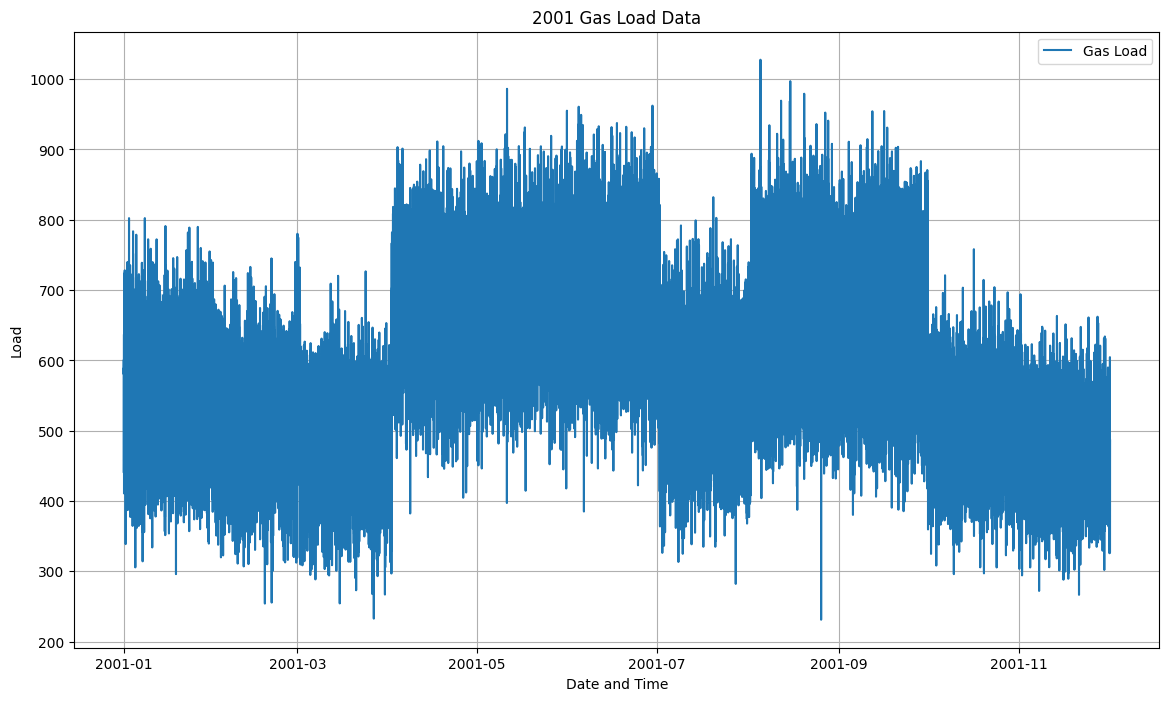

In [7]:
import matplotlib.pyplot as plt
year = 2001

csv_file_path = f'data_adjusted/{year}_adjusted.csv'  # Replace with the actual path to your file

# Reading the CSV file into a pandas DataFrame
data = pd.read_csv(csv_file_path,parse_dates=[0], index_col=0)
first_week_march = data[f'{year}-01-01':f'{year}-12-01']

# Plotting the data for the first week of March
plt.figure(figsize=(14, 8))
# for column in first_week_march.columns:
for column in ['Gas Load']:
    plt.plot(first_week_march.index, first_week_march[column], label=column)

plt.title(f'{year} Gas Load Data')
plt.xlabel('Date and Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()


<h1><mark>Integrate 15-minute to hourly</mark><h1>

In [10]:
import pandas as pd
import os
import re  # Regular expressions for parsing

# Directory containing the CSV files
directory = 'data_adjusted'  # Make sure this path is correct
output_dir = 'data_adjusted_hourly'  # Directory to save the hourly data
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        print(f"Processing {filename}")
        
        # Extract the year from the filename
        match = re.match(r"(\d{4})_adjusted\.csv", filename)
        if not match:
            print(f"Filename '{filename}' doesn't match expected pattern.")
            continue
        
        year = match.group(1)  
        filepath = os.path.join(directory, filename)
        output_path = os.path.join(output_dir, f"{year}_hourly.csv")
        
        try:
            df = pd.read_csv(filepath, index_col=0, parse_dates=True)

            # Resample to hourly and aggregate by summing
            hourly_data = df.resample('H').sum()

            print(f'len of hourly {len(hourly_data)}')
            hourly_data.to_csv(output_path)
        
        except Exception as e:
            print(f"Error processing '{filename}': {e}")



Processing 2005_adjusted.csv
len of hourly 8760
Processing 2002_adjusted.csv
len of hourly 8760
Processing 2017_adjusted.csv
len of hourly 8760
Processing 2010_adjusted.csv
len of hourly 8760
Processing 2020_adjusted.csv
len of hourly 8760
Processing 2011_adjusted.csv
len of hourly 8760
Processing 2016_adjusted.csv
len of hourly 8760
Processing 2003_adjusted.csv
len of hourly 8760
Processing 2004_adjusted.csv
len of hourly 8760
Processing 2009_adjusted.csv
len of hourly 8760
Processing 2008_adjusted.csv
len of hourly 8760
Processing 2018_adjusted.csv
len of hourly 8760
Processing 2019_adjusted.csv
len of hourly 8760
Processing 2014_adjusted.csv
len of hourly 8760
Processing 2013_adjusted.csv
len of hourly 8760
Processing 2006_adjusted.csv
len of hourly 8760
Processing 2001_adjusted.csv
len of hourly 8760
Processing 2007_adjusted.csv
len of hourly 8760
Processing 2012_adjusted.csv
len of hourly 8760
Processing 2015_adjusted.csv
len of hourly 8760


<h2>copy Fred's generation data<\h2>

In [28]:
import pandas as pd
import os
import re  # Regular expressions for parsing

# Directory containing the CSV files
directory = 'data_adjusted_hourly'  
output_dir = 'data_hourly'  # Directory to save the hourly data
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        print(f"Processing {filename}")
        
        # Extract the year from the filename
        match = re.match(r"(\d{4})_hourly\.csv", filename)
        if not match:
            print(f"Filename '{filename}' doesn't match expected pattern.")
            continue
        
        year = match.group(1)  
        filepath = os.path.join(directory, filename)
        generation_file_path = os.path.join('MOPTA_Data_2024-05-02', f'GenerationData{year}.csv')
        output_path = os.path.join(output_dir, f"{year}_hourly.csv")
        print('output path: ',output_path)
        try:
            df = pd.read_csv(filepath, index_col=0, parse_dates=True)
            g_df = pd.read_csv(generation_file_path)
            # print(df.head())
            if len(df) == len(g_df):
                df['Solar'] = g_df['PV'].values
                df['Wind'] = g_df['windpower'].values
            else:
                print("DataFrames do not match in length.") 
            # print('----------')
            # print(df.head())
            df.to_csv(output_path)
        except Exception as e:
            print(f"Error processing '{filename}': {e}")




Processing 2012_hourly.csv
output path:  data_hourly/2012_hourly.csv
Processing 2003_hourly.csv
output path:  data_hourly/2003_hourly.csv
Processing 2006_hourly.csv
output path:  data_hourly/2006_hourly.csv
Processing 2020_hourly.csv
output path:  data_hourly/2020_hourly.csv
Processing 2017_hourly.csv
output path:  data_hourly/2017_hourly.csv
Processing 2010_hourly.csv
output path:  data_hourly/2010_hourly.csv
Processing 2001_hourly.csv
output path:  data_hourly/2001_hourly.csv
Processing 2018_hourly.csv
output path:  data_hourly/2018_hourly.csv
Processing 2004_hourly.csv
output path:  data_hourly/2004_hourly.csv
Processing 2015_hourly.csv
output path:  data_hourly/2015_hourly.csv
Processing 2009_hourly.csv
output path:  data_hourly/2009_hourly.csv
Processing 2007_hourly.csv
output path:  data_hourly/2007_hourly.csv
Processing 2016_hourly.csv
output path:  data_hourly/2016_hourly.csv
Processing 2013_hourly.csv
output path:  data_hourly/2013_hourly.csv
Processing 2002_hourly.csv
output 

In [2]:
import pandas as pd
import os

# Set the directory where your CSV files are stored
directory = 'data_hourly'

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('_hourly.csv'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Modify the columns (replace 'column1' and 'column2' with actual column names)
        # For example, you might want to add 10 to each value in these columns
        print(df)
        # df['column1'] = df['column1'] + 10
        # df['column2'] = df['column2'] * 2

        # Save the modified DataFrame back to CSV
        # df.to_csv(file_path, index=False)
        print(f'Processed and saved: {filename}')
        break


                           1_i        2_i         1_r         2_r         3_r  \
2012-01-01 00:00:00  40.361293  24.789267   28.323515   50.764648   48.747912   
2012-01-01 01:00:00  40.262804  23.534214   22.686941   43.840660   52.577429   
2012-01-01 02:00:00  36.178445  23.271339   21.730228   36.432381   46.199899   
2012-01-01 03:00:00  46.224893  26.143639   20.667628   41.578434   47.417751   
2012-01-01 04:00:00  68.398831  24.007711   41.075104   40.711273   46.847062   
...                        ...        ...         ...         ...         ...   
2012-12-30 19:00:00  83.379818  89.592328  106.350150  126.550462  109.825397   
2012-12-30 20:00:00  59.901774  65.435415   95.253056  122.748501   88.782341   
2012-12-30 21:00:00  40.254058  44.671650   83.841772  106.346543   74.105910   
2012-12-30 22:00:00  28.485592  33.830496   61.161090   85.355595   55.590354   
2012-12-30 23:00:00  20.677960  28.248626   41.486537   70.175782   36.799521   

                           